# Q-Learning - Saving Sirius Black

1. ¿Cómo planeas penalizar y premiar al agente?
    START, FLOOR -> 1 
    OUT OF RANGE -> -10 >> END OF EPISODE
    GOAL -> 126 >> END OF EPISODE
2. Encuentra el optimal policy y grafica el average reward over time.

3. ¿Qué sucede si no hay vientos? ¿Cómo luce el optimal policy y el average reward over time? Comenta tus resultados.


### PARAMETROS
learning_rate, discount_rate 
rewards? -> maneras de penalizar/beneficiar
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.005

#### Libraries used

In [264]:
import numpy as np
import gym
import random
import time
from IPython.display import clear_output
from matplotlib import pyplot as plot
import numpy as np

#### Set up GAME ENVIRONMENT:
    1. STATE CLASS:
    State class represents a state in the game. A state represents a position in the game board, consisting of x and y:

In [265]:
class State:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    2. ACTION SPACE:
    There are 4 possible actions for Harry: move up, move down, move left, and move right. We define these actions as lambda functions that receive a State and return a new updated State by performing the corresponding action:
    The action space size is 4 as there are 4 possilbe actions, and the state space size is 63, since there are 9 columns and 7 rows in the game board matrix.

In [266]:
up = lambda state: State(state.x, state.y-1)
down = lambda state: State(state.x, state.y+1)
left = lambda state: State(state.x - 1, state.y)
right = lambda state: State(state.x + 1, state.y)
action_space_size = 4
state_space_size = 63
action_space = [up, down, left, right]

print(action_space_size,state_space_size)

4 63


    Testing actions:

In [267]:
a = State(1,1)
print(up(State(1,2)), down(a), left(a), right(a))

<__main__.State object at 0x0000020DCFFF6100> <__main__.State object at 0x0000020DE602A5E0> <__main__.State object at 0x0000020DE72D6760> <__main__.State object at 0x0000020DE5F202E0>


##### Function get_sample:
    This function returns a random action from the action_space.

In [268]:
def get_sample():
    random_pos = np.random.randint(0,4)
    return action_space[random_pos], random_pos

###### Function get_num_state: 
    Each action has a corresponding identifier (integer). This function returns this identifier.

In [269]:
def get_num_state(state):
    return state.y*9 + state.x

In [270]:
get_num_state(State(8,6))

62

###### Function reset: 
    This function resets the game state, returning the initial state for Harry.

In [271]:
def reset():
    initial_state = State(1,1)
    return initial_state,get_num_state(initial_state)

###### Function is_goal_state: 
    Determines if the state is the goal state.

In [272]:
def is_goal_state(state):
    return state.x == 7 and state.y == 4

In [273]:
is_goal_state(State(7,4))

True

##### Function get_reward:
    Returns the reward for a given state:
    If state is out of range (out of the game board boundaries), reward is -10
    If state is goal state, reward is 126
    If state is any other state, reward is -1

In [274]:
def get_reward(state):
    if state.x not in range(9) or state.y not in range(7):
        return -10
    if is_goal_state(state):
        return 126
    return -1

In [275]:
get_reward(State(1,6))

-1

##### Function move:
    Performs an action in a given state, taking into account the wind probabilities for the game:
        wind_val is a dictionary containing the columns of wind as keys and the probability tresholds as values
    Returns the resulting state of performing the action on a given state, the reward of performing that action, and a boolean value, done, which is True if the game is over (if Harry gets out of the game board or reaches Sirius).
    If the action leads to the agent getting out of the game board, new_state will be None, because that position does not exist and is not present on the q-table.

In [276]:
wind_val = {3:0.1, 4:0.2, 5:0.15}

In [277]:
def move(state, action):
    new_state = action(state)
    wind_treshold = np.random.random()
    wind_prob = wind_val.get(new_state.x)
    if wind_prob:
        if wind_treshold < wind_prob:
            new_state.y -= 1
    reward = get_reward(new_state)
    done = is_goal_state(new_state) or reward == -10
    if reward == -10:
        new_state = None
    return new_state, reward, done

##### Initialize some parameters
    We will have 15000 episodes performed, with 100 steps of limit for one episode, to avoid infinite cycles.
###### VERSION 1: 
    - learning rate = 0.2
    - discount rate = 0.95

In [278]:
num_episodes = 15000
max_steps_per_episode = 100

learning_rate = 0.2
discount_rate = 0.95
#learning_rate = 0.8
#discount_rate = 0.99


rewards_avg = []

q_table = np.zeros((state_space_size, action_space_size))

#### Q-LEARNING Algorithm:
    This algorithm is based on the Frozen-lake lab algorithm. It performs 15000 episodes, 100 times in order to view the average of the 100 times and verify if the agent is really learning to maximize its reward.
    We are taking into account that when the agent gets out of the game board (meaning new_state = None when performing move function), the new state will be the prior state. This is based on analizing the way the Frozen-lake lab handled the same case. If this is not done, q-table would try to find a value out of range when updating.

In [281]:
# This cycle is to calculate the average reward/episodes and its only purpose is to plot the nice graph below that
# shows how the agent learns to maximize the reward.
rewards_avg = []
q_table_avg = []
for it in range(100):
    print('average ', it)
    rewards_all_episodes=[]
    q_table_all_episodes = []
    
    # exporation-exploitation trade-off params
    exploration_rate = 1
    max_exploration_rate = 1
    min_exploration_rate = 0.01
    exploration_decay_rate = 0.005
    
    # init q table in zeros
    q_table = np.zeros((state_space_size, action_space_size))

    # iterate over the episodes
    for episode in range(num_episodes):
        state, num_state = reset()
        done = False
        rewards_current_episode = 0
        
        # iterate over the steps for an episode
        for step in range(max_steps_per_episode):
            # Exploration-exploitation trade-off
            exploration_rate_threshold = np.random.random()
            if exploration_rate_threshold <= exploration_rate:
                action, pos_action = get_sample()
            else:
                q_row = q_table[num_state]
                pos_action = np.where(q_row == max(q_row))[0][0]
                action = action_space[pos_action]
            # Take action
            new_state, reward, done = move(state, action)
            if new_state == None:
                num_new_state = get_num_state(state)
            else:
                num_new_state = get_num_state(new_state)
            # Update Q-table for Q(s,a)
            max_value = max(q_table[num_new_state])
            future_q=learning_rate*(reward + discount_rate*max_value)
            q_table[num_state, pos_action] = (1-learning_rate)*q_table[num_state,pos_action] + future_q
            
            # transition next state
            state = new_state
            num_state = num_new_state
            rewards_current_episode += reward

            if done == True: 
                break

        # Exploration rate decay
        exploration_rate = min_exploration_rate + (max_exploration_rate-min_exploration_rate) * np.exp(-exploration_decay_rate*episode)

        rewards_all_episodes.append(rewards_current_episode)
        q_table_all_episodes.append(q_table)
    rewards_avg.append(rewards_all_episodes)
    q_table_avg.append(q_table_all_episodes)

average  0
average  1
average  2
average  3
average  4
average  5
average  6
average  7
average  8
average  9
average  10
average  11
average  12
average  13
average  14
average  15
average  16
average  17
average  18
average  19
average  20
average  21
average  22
average  23
average  24
average  25
average  26
average  27
average  28
average  29
average  30
average  31
average  32
average  33
average  34
average  35
average  36
average  37
average  38
average  39
average  40
average  41
average  42
average  43
average  44
average  45
average  46
average  47
average  48
average  49
average  50
average  51
average  52
average  53
average  54
average  55
average  56
average  57
average  58
average  59
average  60
average  61
average  62
average  63
average  64
average  65
average  66
average  67
average  68
average  69
average  70
average  71
average  72
average  73
average  74
average  75
average  76
average  77
average  78
average  79
average  80
average  81
average  82
average  83
av

#### Plotting Episodes Vs Reward
    We can observe how the agent learns to maximize its reward:

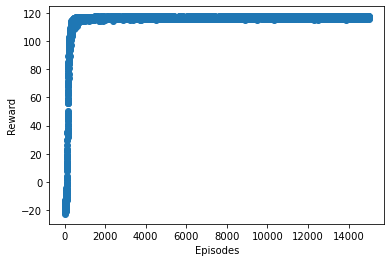

In [282]:
x = [i for i in range(0,num_episodes)]
y = np.mean(rewards_avg, axis=0)
plot.xlabel('Episodes')
plot.ylabel('Reward')
plot.plot(x, y,'o')

#### Visualizing Optimal Policy:
    Each number of the resulting matrix represents the best action for each corresponding state:
        0 -> UP
        1 -> DOWN
        2 -> LEFT
        3 -> RIGHT

In [285]:
#action_space = [up, down, left, right]  
state_best_actions =[]
arrow_matrix = []
for i in range(q_table.shape[0]):
    max_pos = np.argmax(q_table[i])
    state_best_actions.append(max_pos)
arrow_matrix = np.array(state_best_actions).reshape(7,9)

#### Visualizing with arrows:
    To have a better view, we graph with arrows:

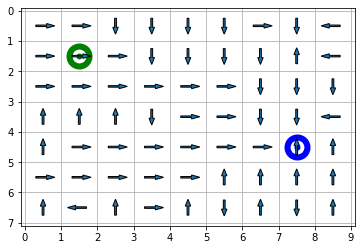

In [286]:
import matplotlib.pyplot as plt
best_actions_matrix = np.array(state_best_actions).reshape(7,9)
w = 0.3
arrow_dict = {0:lambda i,j:plt.arrow(x=i, y=j-0.25, dx=0, dy=w, width=.05)  ,1:lambda i,j:plt.arrow(x=i, y=j+0.25, dx=0, dy=-w, width=.05),2:lambda i,j:plt.arrow(x=i+0.2, y=j, dx=-w, dy=0, width=.05),3:lambda i,j:plt.arrow(x=i-0.2, y=j, dx=w, dy=0, width=.05)}
i,j=0,0
arrow_matrix=np.transpose(np.array(arrow_matrix).reshape(7,9))
for j in range(len(arrow_matrix)):
    for i in range(len(arrow_matrix[j])):
#         print(i,j)
        arrow_dict[best_actions_matrix[i,j]](j+0.5,(6-i)+0.5)
start = [1,1]
goal = [7,4]
plt.scatter(start[0]+0.5,6-start[1]+0.5, color="green", linewidths=20)
plt.scatter(goal[0]+0.5,6-goal[1]+0.5, color = "blue",linewidths=20)

plt.xticks(np.arange(9,-1, -1))
plt.yticks(np.arange(7,-1, -1),labels= ["0","1","2","3","4","5","6","7"])
plt.grid()
# display plot 
plt.show()

    As we can see above, as there are winds, meaning there is high probability of getting out of the game board if the agent is near the top border(row 0), we see that the arrow of the 3 columns (3,4,5) in row 0 and 1 are downards. This guarantees that the agent does not get out of the game board, and it leads to the goal state.

In [288]:
# Print updated Q-table
print("\n\n********Q-table********\n")
print(q_table)



********Q-table********

[[-7.35600717e+00 -3.00502700e+00 -8.75963162e+00  1.71729575e+00]
 [-9.63688856e+00  1.12697562e+01 -2.37257668e+00  6.89324121e+01]
 [ 1.29943832e+01  7.41629779e+01  4.85765556e+00  1.88758280e+01]
 [-1.78879237e+00  7.84139074e+01  2.14577908e+01  3.29249770e+01]
 [-6.07680819e+00  8.28442101e+01  1.01716231e+01 -6.83120000e-01]
 [-4.94840000e+00  8.18891877e+01 -5.93716000e-01 -7.71120000e-01]
 [-3.60000000e+00 -6.59760000e-01 -5.25056800e-01 -4.88000000e-01]
 [-2.00000000e+00 -2.00000000e-01 -2.50996000e-01 -2.00000000e-01]
 [-2.00000000e+00 -2.00000000e-01  0.00000000e+00  0.00000000e+00]
 [-2.88233834e+00  1.82549767e+01 -1.06823458e+01  6.96917878e+01]
 [ 6.37926213e+01  7.38903135e+01  6.51141291e+01  7.39367889e+01]
 [ 6.34549603e+01  6.02895815e+01  6.15085292e+01  7.87780986e+01]
 [ 7.09907867e+01  8.38600652e+01  7.30438418e+01  8.12166313e+01]
 [ 4.70466059e+01  9.18059838e+01  7.08945331e+01  6.55576236e+01]
 [ 5.20505268e+01  9.68353863e+01  

# EXPERIMENTS:

In [253]:
def get_reward(state):
    if state.x not in range(9) or state.y not in range(7):
        return 0
    if is_goal_state(state):
        return 1
    return 0

## WITHOUT WIND

In [254]:
def move_without_wind(state, action):
    #print(action)
    new_state = action(state)
    #print(new_state.x)
    reward = get_reward(new_state)
    #print(state.x, state.y , "r = ",reward)
    done = is_goal_state(new_state) or reward == -10
    if reward == -10:
        new_state = None
    return new_state, reward, done

In [255]:
s,r,d = move_without_wind(State(0,3), down)
print("pos: ",s.x,s.y,"| reward: ", r,"| done = ",d)

pos:  0 4 | reward:  0 | done =  False


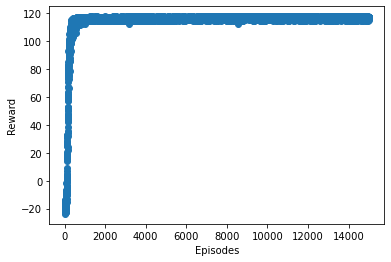

In [256]:
x = [i for i in range(0,num_episodes)]
y = np.mean(rewards_avg, axis=0)
plot.xlabel('Episodes')
plot.ylabel('Reward')
plot.plot(x, y,'o')

In [257]:
print(max(np.mean(rewards_avg, axis=0)))
pos_max_reward = np.argmax(np.mean(rewards_avg, axis=0))
print(pos_max_reward)

117.76
9836


In [258]:
#504 15000
print(rewards_avg[0][0])

-19


In [259]:
print(np.mean(rewards_avg, axis=0)[pos_max_reward])

117.76


In [260]:
print(len(rewards_avg))
print(len(q_table_avg))

50
50


In [261]:
print(len(rewards_avg[0]))
print(len(q_table_avg[0]))

15000
15000


In [262]:
r = np.array(rewards_avg).flatten()
print(len(r))

750000


In [263]:
print(np.argmax(r))

156


In [266]:
print(rewards_avg[0][155])

224


In [103]:
bq = q_table_avg[0][pos_max_reward]#.round(1)
state_best_actions =[]
for i in range(bq.shape[0]):
    state_best_actions.append(np.where(bq[i] == max(bq[i]))[0][0])
    #action_space = [up, down, left, right]
np.array(state_best_actions).reshape(7,9)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 3, 2, 0, 1],
       [2, 2, 1, 1, 1, 0, 0, 0, 1],
       [2, 2, 1, 1, 1, 1, 2, 0, 0],
       [2, 3, 3, 1, 1, 2, 0, 0, 0],
       [2, 0, 1, 2, 3, 3, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 0, 0]], dtype=int64)

In [104]:
print(bq)#.round(1))

[[ 0.         -0.91410065  0.         -0.5904    ]
 [ 0.         -1.94999966 -0.99999902 -0.99999808]
 [ 0.         -1.70222964 -0.95601953 -0.93128052]
 [ 0.         -0.36959891 -0.488      -0.36      ]
 [ 0.         -0.2684     -0.2        -0.36      ]
 [ 0.         -0.5904      0.         -0.2       ]
 [ 0.          0.         -0.2         0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.99900965 -0.977482    0.         -1.90292378]
 [-1.         -1.94999639 -1.         -1.95      ]
 [-1.         -1.61858666 -1.89218802 -1.52353445]
 [-0.91410065 -0.9573896  -0.97016711 -0.97630144]
 [-0.488      -0.61112    -0.83485063 -0.8304608 ]
 [-0.488      -0.53322    -0.599796   -0.36      ]
 [-0.2        -0.2         0.         -0.2       ]
 [ 0.          0.          0.         -0.2       ]
 [-0.2         0.          0.          0.        ]
 [-0.737856   -0.36        0.         -1.51264931]
 [-1.79265202 -1.47477788 -0.99

In [226]:
best_q_table = np.mean(q_table_avg, axis=0)[pos_max_reward]
print(best_q_table.shape)

(63, 4)


In [227]:
state_best_actions =[]
for i in range(best_q_table.shape[0]):
    state_best_actions.append(np.argmax(best_q_table[i]))
    #action_space = [up, down, left, right]

In [228]:
print(state_best_actions)

[1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 3, 3, 1, 1, 2, 1, 2, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 0, 2, 0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 3, 3, 0, 0, 0, 0, 0, 0, 0]


In [229]:
#action_space = [up, down, left, right]
len(state_best_actions)
np.array(state_best_actions).reshape(7,9)

array([[1, 1, 1, 1, 1, 2, 1, 1, 1],
       [1, 3, 3, 3, 1, 1, 2, 1, 2],
       [3, 3, 3, 3, 3, 3, 1, 1, 1],
       [3, 3, 3, 3, 3, 3, 1, 0, 2],
       [0, 0, 3, 3, 3, 3, 0, 0, 0],
       [0, 0, 0, 0, 3, 0, 0, 0, 2],
       [3, 3, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [261]:
# Print updated Q-table
print("\n\n********Q-table********\n")
print(q_table)



********Q-table********

[[-1.02253891e+00  1.66703626e+02  3.44478585e+01  1.49837130e+00]
 [ 4.34427568e+01  9.32790815e+00  4.01116783e+01  2.05501282e+02]
 [ 8.15863731e+00  5.53237626e+01  1.01592120e+01  2.57232009e+02]
 [ 1.95115801e+02  2.69342472e+02  1.65598959e+02  1.89159563e+02]
 [ 2.07218916e+02  2.91830978e+02  1.85446549e+02  2.07085532e+02]
 [ 4.00301067e+01  5.13109759e+01  7.54955297e+00  2.89224313e+02]
 [ 1.38867342e+02  1.86608968e+02  2.01833873e+02  2.64102273e+02]
 [ 2.24044466e+02  2.23918952e+02  2.23486084e+02  2.24359106e+02]
 [ 1.80856508e+02  2.43580340e+02  1.08719714e+02  2.06707165e+02]
 [ 2.51023944e+00  4.43854744e+01 -1.21490059e+00  2.14496469e+02]
 [ 2.43986132e+02  2.42105168e+02  2.38805685e+02  2.45809843e+02]
 [ 2.63296850e+02  2.63853416e+02  2.29680127e+02  2.62556819e+02]
 [ 2.63430587e+02  2.67021617e+02  2.64571160e+02  2.62541139e+02]
 [ 2.95992206e+02  2.96871357e+02  2.92798380e+02  2.96542825e+02]
 [ 2.36053470e+02  3.00517201e+02  

In [302]:
print(max(np.mean(rewards_avg, axis=0)))
pos_max_reward = np.argmax(np.mean(rewards_avg, axis=0))
print(pos_max_reward)
print(np.mean(rewards_avg, axis=0)[pos_max_reward])
best_q_table = q_table_all_episodes[pos_max_reward]
print(q_table.shape)
state_best_actions =[]
for i in range(q_table.shape[0]):
    state_best_actions.append(np.argmax(q_table[i]))
    #action_space = [up, down, left, right]
len(state_best_actions)
np.array(state_best_actions).reshape(7,9)

114.5
3428
114.5
(63, 4)


array([[3, 1, 3, 3, 2, 3, 3, 2, 2],
       [1, 1, 1, 1, 1, 0, 1, 2, 1],
       [0, 3, 3, 1, 1, 2, 1, 2, 1],
       [3, 3, 3, 1, 1, 1, 1, 0, 2],
       [3, 0, 0, 1, 3, 1, 3, 0, 0],
       [1, 0, 2, 3, 3, 3, 0, 0, 0],
       [1, 0, 3, 1, 3, 0, 2, 0, 0]], dtype=int64)